In [1]:
from IPython.display import display 
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy import matlib

In [2]:
from mpl_toolkits.mplot3d import Axes3D

# Observe images

In [4]:
img_left = cv2.imread('pic_left.png')
img_right = cv2.imread('pic_right.png')

<IPython.core.display.Javascript object>


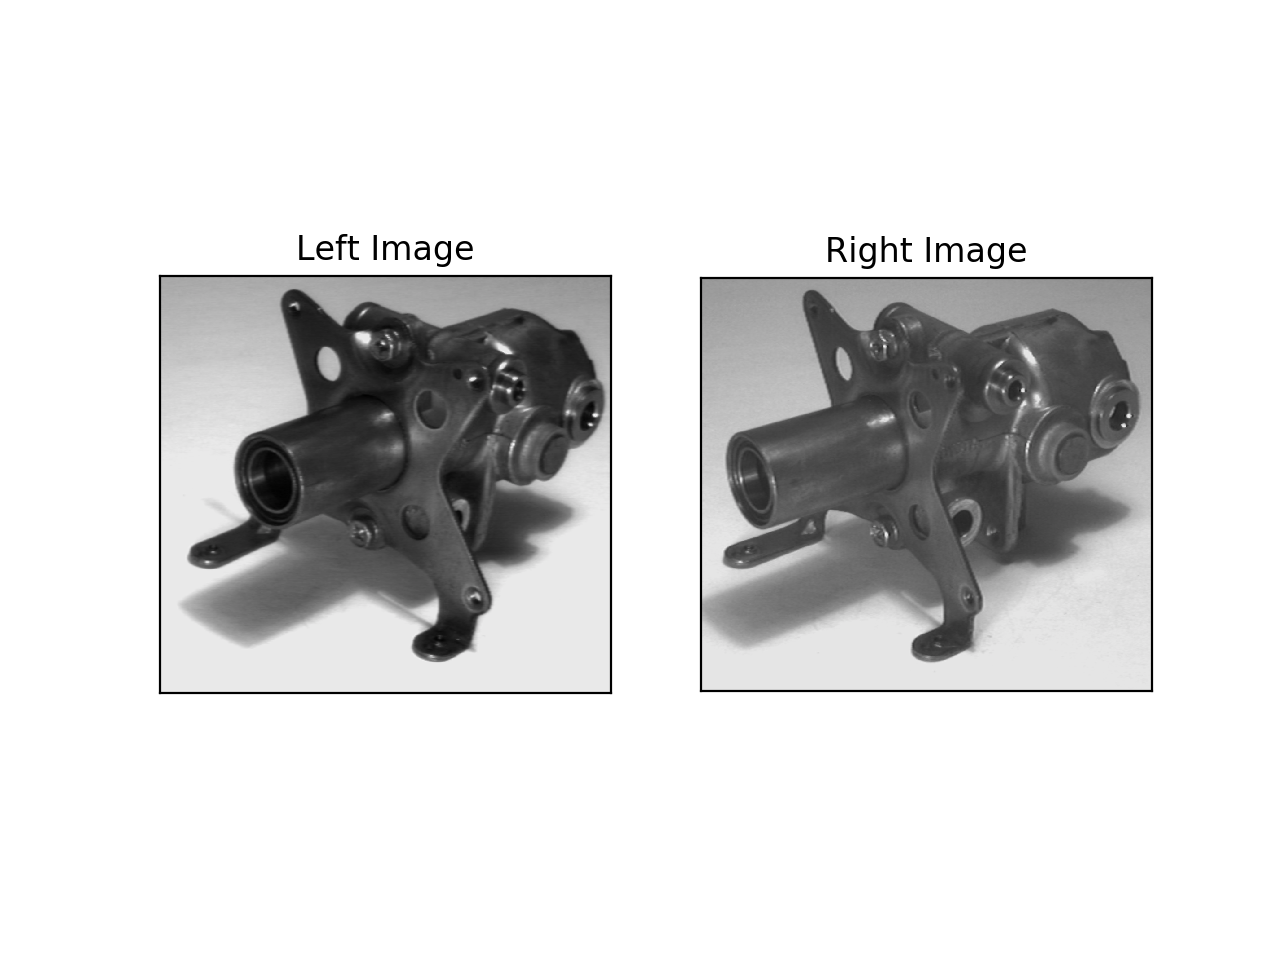

(Text(0.5,1,u'Right Image'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

In [38]:
plt.subplot(121),plt.imshow(img_left,cmap = 'gray')
plt.title('Left Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_right,cmap = 'gray')
plt.title('Right Image'), plt.xticks([]), plt.yticks([])

# Find edges

In [7]:
edges_left = cv2.Canny(img_left,10,100)
edges_right = cv2.Canny(img_right,10,100)

<IPython.core.display.Javascript object>


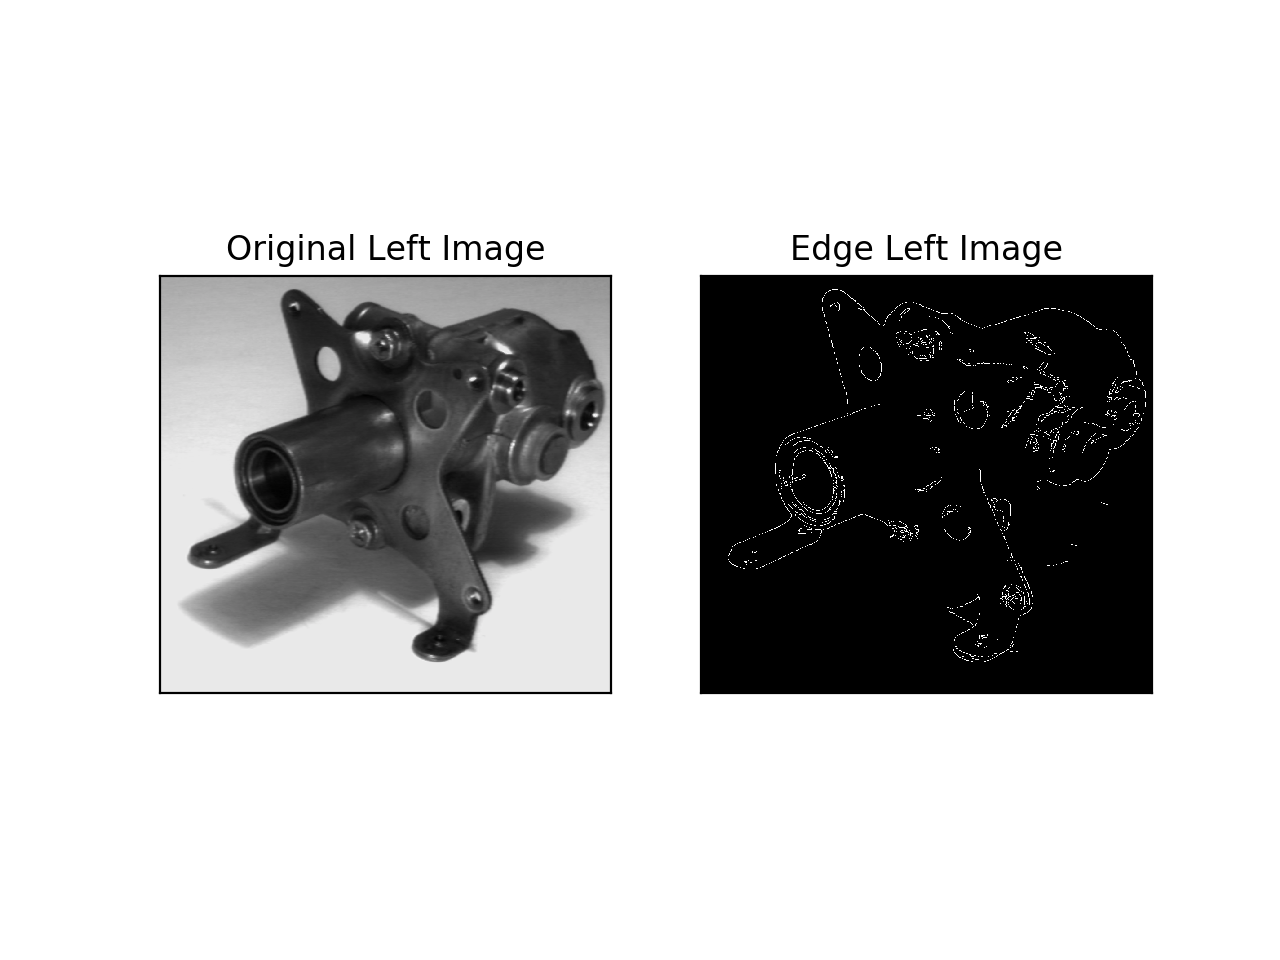

In [36]:
plt.subplot(121),plt.imshow(img_left,cmap = 'gray')
plt.title('Original Left Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges_left,cmap = 'gray')
plt.title('Edge Left Image'), plt.xticks([]), plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


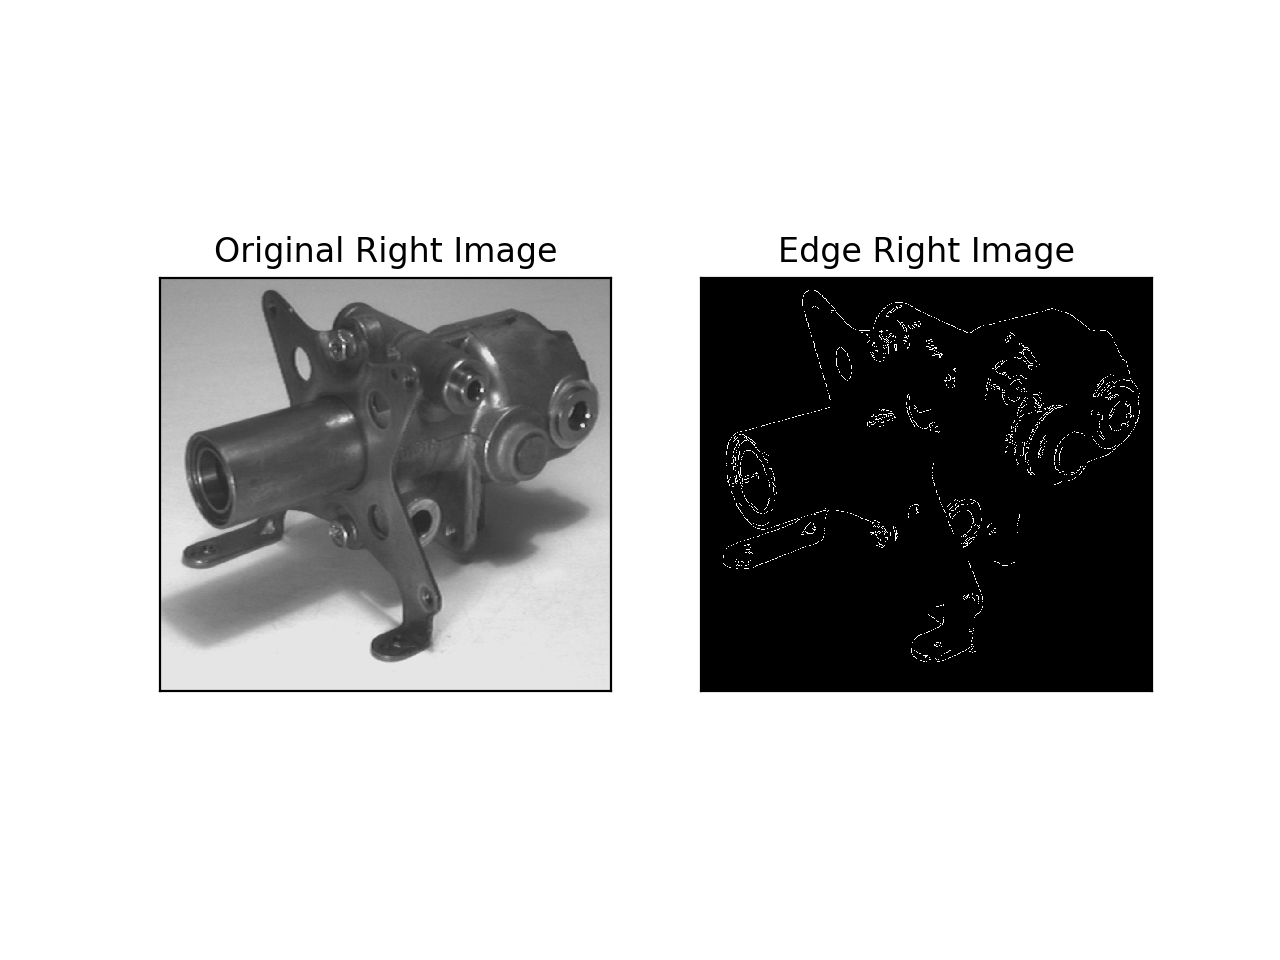

In [37]:
plt.subplot(121),plt.imshow(img_right,cmap = 'gray')
plt.title('Original Right Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges_right,cmap = 'gray')
plt.title('Edge Right Image'), plt.xticks([]), plt.yticks([])

plt.show()

# Get Candidates Matching

In [35]:
num_rows = img_left.shape[0]

In [12]:
array_of_disparities = list()

In [13]:
for r in range(0,num_rows):
    left_edge_pixels = np.flatnonzero(edges_left[r])
    for i in left_edge_pixels:
        i1 = np.flatnonzero(edges_right[r])
        disparities = (i1-i)
        num_matches = len(disparities)
        left_coords = np.matlib.repmat([i,r],num_matches,1)
        array_of_disparities.append(np.c_[left_coords,disparities])

# Find the best match with SSD

In [17]:
def pix_to_window(coord_x,coord_y,img):
    row, col, _ = img.shape
    if (coord_x == row) and (coord_y == col):
        mat = [[img[row-1][col-1][0], img[row-1][col][0]],[img[row][col-1][0], img[row][col][0]]]
    elif (coord_x == 0) and (coord_y == 0):
        mat = [[img[0][0][0], img[0][1][0]], [img[1][0][0], img[1][1][0]]]
    elif (coord_x == 0) and (coord_y == col):
        mat = [[img[0][col-1][0], img[0][col][0]], [img[1][col-1][0], img[1][col][0]]]
    elif (coord_x == row) and (coord_y == 0):
        mat = [[img[row-1][0][0], img[row-1][1][0]], [img[row][0][0], img[row][1][0]]]
    elif coord_x == 0:
        mat = [[img[0][coord_y-1][0], img[0][coord_y][0]], [img[0][coord_y+1][0], img[1][coord_y][0]]]
    elif coord_x == row:
        mat = [[img[row][coord_y-1][0], img[row][coord_y][0]], [img[row-1][coord_y][0], img[row][coord_y+1][0]]]
    elif coord_y == 0:
        mat = [[img[coord_x-1][0][0], img[coord_x][0]][0], [img[coord_x][1][0], img[coord_x+1][0][0]]]
    elif coord_y == col:
        mat = [[img[coord_x-1][col][0], img[coord_x][col][0]], [img[coord_x][col-1][0], img[coord_x+1][col][0]]]
    else:
        mat = [[img[coord_x-1][coord_y][0], img[coord_x][coord_y][0]], [img[coord_x][coord_y-1][0], img[coord_x][coord_y+1][0]]]
    return mat

In [18]:
def ssd(img1,img2):
    return int(np.sum((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32))**2))

## Compute SSD on window around candidate coordinates

In [19]:
coord_ssd = list()
for candidate in array_of_disparities:
    tmp_ssd = [[m[0],
                m[1],
                m[2],
                ssd(pix_to_window(m[1],m[0],img_left),pix_to_window(m[1],m[0]+m[2],img_right))] 
               for m in candidate]
    coord_ssd.append(tmp_ssd)

## Pick best match (minimum SSD value)

In [20]:
final_list = list()
for candidate in coord_ssd:
    if candidate:
        min_ssd = min(map(lambda x: x[3],candidate))
        best_match = filter(lambda x: x[3]==min_ssd,candidate)[0]
        final_list.append(best_match)

# Compute the Z coordinates of each point (Z prop to 1.0/(k+disparity))

In [23]:
pixel_size = 0.011
k = 8.3154e+03

In [24]:
coordinates_not_real = list()

In [25]:
for a in final_list:
    coord_xleft = a[1]
    coord_yleft = a[0]
    coord_z = 1.0/(k+a[3]*pixel_size)
    coord_xright = a[1]
    coord_yright = a[0]+a[2]
    coordinates_not_real.append([coord_xleft,coord_yleft,coord_z,coord_xright,coord_yright])

# Real world coordinates

In [27]:
coordinates_real = list()

In [28]:
focal = 17

In [29]:
for b in coordinates_not_real:
    real_x = b[2] * pixel_size * b[0] / focal
    real_y = b[1] * pixel_size * b[2] / focal
    coordinates_real.append([real_x,real_y,b[2]])

In [30]:
X = list(map(lambda x: x[0],coordinates_real))
Y = list(map(lambda x: x[1],coordinates_real))
Z = list(map(lambda x: x[2],coordinates_real))

# Final Result

In [31]:
%matplotlib notebook

<IPython.core.display.Javascript object>


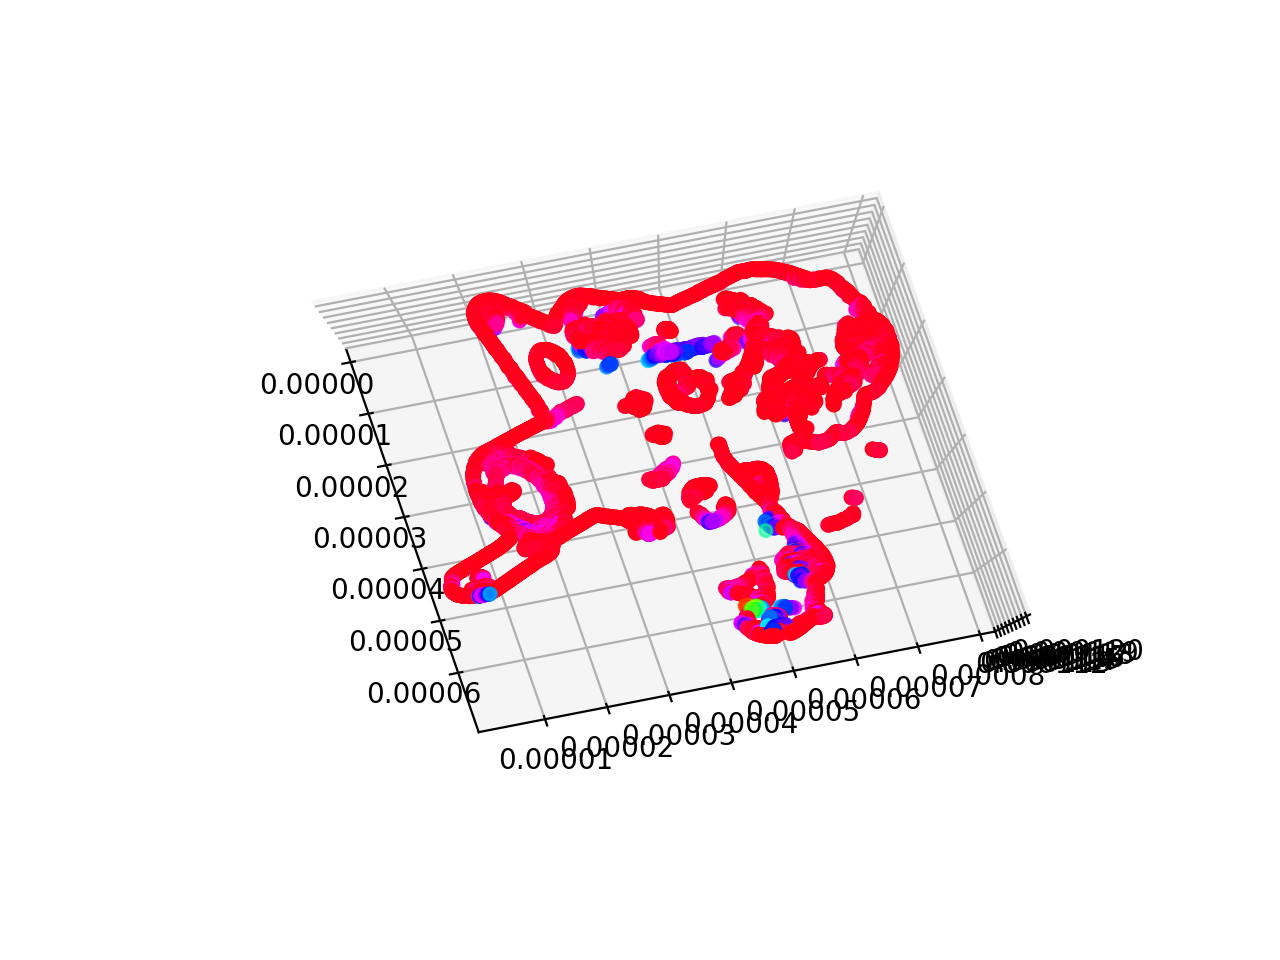

In [33]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X, Y, Z, c=Z, cmap='hsv');

plt.show()